<a id="section_toc"></a> 
## Tabla de Contenidos

[0 - Imports y definiciones](#section_0)

[1 - Primer Analisis del Data Frame](#section_1)

[2 - Imputacion de datos faltantes](#section_2)

[3 - Primer modelado: Naive Bayes](#section_3)

[4 - Segundo modelado: LR](#section_4)

[5 - Tercer modelado: LR & KNN](#section_5)

[6 - Modelos no usados para la presentación](#section_6)

<a id="section_0"></a> 
# 0 - Imports y definiciones
[volver a TOC](#section_toc)

In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
# Matriz de confusión con los yticks centrados

def conf_mat(y_test, Y_pred, umbral):

    conf_mat = confusion_matrix(y_test, Y_pred)
    conf_mat_df = pd.DataFrame(data=conf_mat, 
                               index=['Actual Negative: 0', 'Actual Positive: 1'], 
                               columns=['Predict Negative: 0', 'Predict Positive: 1'])

    fig, ax = plt.subplots()
    ax = sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='YlGnBu', ax= ax)
    ax.set_title(f'Matriz de confusión. Umbral = {umbral}')
    ax.set_yticklabels(list(conf_mat_df.index), rotation=90, va="center");

In [3]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    
    def __init__(self, selected_features):
        self.selected_features=selected_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.selected_features]

<a id="section_1"></a> 
# 1 - Primer Analisis del Data Frame
[volver a TOC](#section_toc)

In [4]:
data_path = r"../data/weatherAUS.csv"

data = pd.read_csv(data_path)

nrow, ncol = data.shape  # Guardamos las dimensiones del df

data.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [6]:
(100 * data.isnull().sum() / nrow).round(2)

Date              0.00
Location          0.00
MinTemp           1.02
MaxTemp           0.87
Rainfall          2.24
Evaporation      43.17
Sunshine         48.01
WindGustDir       7.10
WindGustSpeed     7.06
WindDir9am        7.26
WindDir3pm        2.91
WindSpeed9am      1.21
WindSpeed3pm      2.11
Humidity9am       1.82
Humidity3pm       3.10
Pressure9am      10.36
Pressure3pm      10.33
Cloud9am         38.42
Cloud3pm         40.81
Temp9am           1.21
Temp3pm           2.48
RainToday         2.24
RainTomorrow      2.25
dtype: float64

In [7]:
# Revisamos el formato de esta columna

data.RainTomorrow.sample(5)

139492     No
65532      No
85469      No
48337      No
40915     Yes
Name: RainTomorrow, dtype: object

In [8]:
# Convertimos los Yes/No de RainToday/RainTomorrow a dummies

data.replace({'No' : 0, 'Yes' : 1}, value= None, inplace= True)

In [9]:
# Convertimos la columna Date a datetime

data.Date = pd.to_datetime(data.Date, format= '%Y/%m/%d')

In [10]:
data.dtypes

Date             datetime64[ns]
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
Evaporation             float64
Sunshine                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday               float64
RainTomorrow            float64
dtype: object

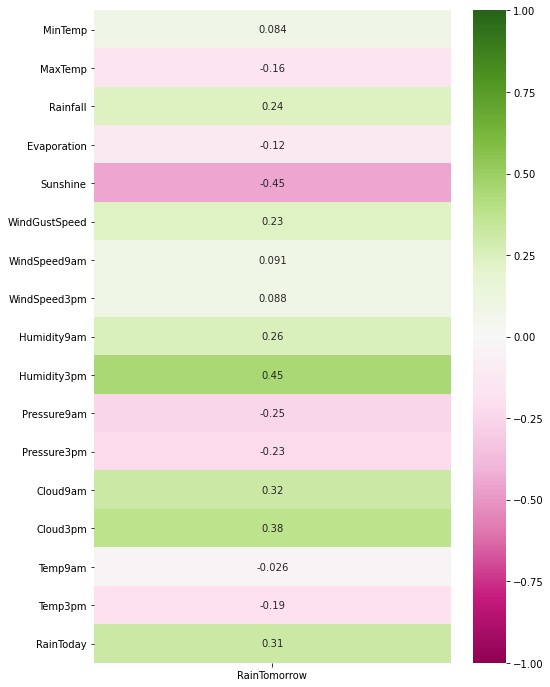

In [11]:
# Chequeamos la correlación entre nuestras features y el target

plt.figure(figsize=(8,12))
sns.heatmap(data.corr()[['RainTomorrow']][:-1], cmap= 'PiYG', center= 0, vmin= -1, vmax= 1, annot=True);

In [12]:
print("filas:", nrow, "\ncolumnas:", ncol)

filas: 145460 
columnas: 23


Para este punto notamos que la feature con mayor correlación, `Sunshine`, tenía también el mayor porcentaje de nulos: 48 %.
Investigando descubrimos que para ciertas localidades no había ningún dato de `Sunshine`. Veamos cuales son:

In [13]:
# pd.Series.all() retorna True salvo que haya al menos un elemento False/None/NaN/0,
# pero para algunas localidades no hay ningún dato de Sunshine y así y todo, .all()
# retorna True. Podemos usar esto para ver qué localidades no tienen ningún dato de
# Sunshine o cualquier otra feature que queramos, aunque si para esa localidad no hay
# ningun False/None/NaN/0 también vamos a tener un True (falso positivo). Verificaremos
# al final que no hayamos caído en este caso.

# Este diccionario nos da {location : True} si son todos vacíos o no hay ningún False/None/NaN/0, caso contrario retorna {location: False}
dict_loc_nulas_sunshine = {key : data.loc[data['Location'] == key, 'Sunshine'].all() for key in data['Location'].unique()}

# Convertimos este diccionario a una lista
loc_nulas_sunshine = [key for key, value in dict_loc_nulas_sunshine.items() if value]

# Chequeamos que no haya ninguna localidad con todos valores no nulos
print('{0:20}  {1}'.format('Location', 'Unique values'))
print('\u2014' * 35)
for i in loc_nulas_sunshine:
    print('{0:20}  {1}'.format(f'{i}:', data.loc[data['Location'] == i, 'Sunshine'].unique()))

Location              Unique values
———————————————————————————————————
Albury:               [nan]
BadgerysCreek:        [nan]
Newcastle:            [nan]
NorahHead:            [nan]
Penrith:              [nan]
Richmond:             [nan]
Wollongong:           [nan]
Tuggeranong:          [nan]
MountGinini:          [nan]
Ballarat:             [nan]
Bendigo:              [nan]
Nhil:                 [nan]
GoldCoast:            [nan]
Witchcliffe:          [nan]
SalmonGums:           [nan]
Walpole:              [nan]
Launceston:           [nan]
Katherine:            [nan]
Uluru:                [nan]


Efectivamente tenemos una lista de localidades donde no hay datos de `Sunshine`. En la próxima sección veremos como imputarlos.

In [14]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [15]:
# Ya que tenemos la columna Date como datetime64, vamos a crear nuevas columnas con año y mes

data['Month'] = data.Date.dt.month
data['Year'] = data.Date.dt.year
data.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,12,2008
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,12,2008


<a id="section_2"></a> 
# 2 - Imputacion de datos faltantes
[volver a TOC](#section_toc)

Vemos del punto anterior que hay varias ciudades sin dato en `Sunshine` y otras features. </br>
Vamos a imputar por el promedio del mes. En el caso de que no tengamos ningun valor en ese mes utilizamos una ciudad cercana de referencia; para esto creamos una nueva columna con ciudades más cercanas.

In [16]:
# Creamos una copia del df pero que sea un objeto aparte
data_para_imputar = data.copy()
data_para_imputar['imputados'] = 0
data_para_imputar["Location_replace"] = data_para_imputar["Location"]

lista_replace = {"Albury" : "Perth", "Uluru" : "Alice Springs", "Penrith" : "Sydney", "Katherine" : "Darwin", "Walpole" : "Perth", \
                 "Launceston" : "Hobart", "Wollongong" : "Sydney", "Badgerys Creek" : "Sydney", "Tuggeranong" : "Wagga Wagga", \
                 "Richmond" : "Melbourne", "Mount Ginini" : "Wagga Wagga", "Bendigo" : "Melbourne", "Salmon Gums" : "Perth Airport", \
                 "Witchcliffe" : "Perth Airport", "Norah Head" : "Sydney", "Nhil" : "Melbourne", "GoldCoast" : "Brisbane", \
                 "Ballarat" : "Melbourne", "Newcastle" : "Sydney"}

data_para_imputar["Location_replace"] = data_para_imputar.Location_replace.replace(lista_replace)

In [17]:
# Generamos una columna con una palabra key para identificar cada linea formado por localidad + numero de mes
# Esto nos resultó más sencillo de implementar que buscar simultaneamente en tres columnas distintas
data_para_imputar["location_mes"] = data_para_imputar['Location_replace'].astype(str)+data_para_imputar['Month'].astype(str)
data_para_imputar.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,imputados,Location_replace,location_mes
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,12,2008,0,Perth,Perth12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,12,2008,0,Perth,Perth12


In [18]:
pivot = data_para_imputar.pivot_table(index= ["Location", "Month"], values=["Sunshine", "Humidity3pm", "Cloud3pm", "Cloud9am" ], aggfunc=[np.mean], dropna= True).round(2)
pivot.sample(5)

mean                              
                    Cloud3pm Cloud9am Humidity3pm Sunshine
Location      Month                                       
Albury        12        4.90     5.54       33.52      NaN
Penrith       12         NaN      NaN       47.11      NaN
PearceRAAF    12        3.72     4.00       30.63    11.51
Watsonia      12        4.84     5.11       45.60     8.75
BadgerysCreek 3          NaN      NaN       56.37      NaN

In [19]:
data_para_imputar.shape

(145460, 28)

In [20]:
# Este código es para transformar la pivot table multiíndice en un df de un solo nivel jerárquico de índices/columnas

pivot_2 = pd.DataFrame(pivot.to_records())
display(pivot_2.sample(5))
pivot_2.dtypes

,Location,Month,"('mean', 'Cloud3pm')","('mean', 'Cloud9am')","('mean', 'Humidity3pm')","('mean', 'Sunshine')"
154,Dartmoor,11,NaN,NaN,55.24,7.61
189,Hobart,10,4.89,4.71,48.14,7.75
354,PearceRAAF,7,4.80,4.31,55.84,6.21
346,Nuriootpa,11,4.69,4.58,31.79,9.70
325,NorfolkIsland,2,5.53,5.55,73.41,6.71


Location                    object
Month                        int32
('mean', 'Cloud3pm')       float64
('mean', 'Cloud9am')       float64
('mean', 'Humidity3pm')    float64
('mean', 'Sunshine')       float64
dtype: object

In [21]:
# Generamos en este nuevo dataframe pivot_2 misma palabra key Nombre ciudad + numero de mes

pivot_2["location_mes"] = pivot_2['Location'].astype(str) + pivot_2['Month'].astype(str)
pivot_2.sample(5)

,Location,Month,"('mean', 'Cloud3pm')","('mean', 'Cloud9am')","('mean', 'Humidity3pm')","('mean', 'Sunshine')",location_mes
579,Woomera,4,2.96,2.93,31.49,8.68,Woomera4
30,Albury,7,6.26,7.07,67.40,NaN,Albury7
212,Launceston,9,6.12,5.91,59.33,NaN,Launceston9
133,CoffsHarbour,2,4.57,4.89,67.52,7.82,CoffsHarbour2
18,Albany,7,5.43,4.96,66.61,5.18,Albany7


In [22]:
# Unimos ambos data frame a traves de nuestra columna de location + mes
# Al ser inner se pierden un poco de datos que quedaron sin linkear (habria que revisar la lista replace de lugares etc)
# podriamos poner how = left para tener la totalidad de datos

data_imputados = pd.merge(data_para_imputar, pivot_2, on= 'location_mes', how= 'inner')

display(data_imputados.shape)
data_imputados.sample(5)

(137834, 34)

,Date,Location_x,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month_x,Year,imputados,Location_replace,location_mes,Location_y,Month_y,"('mean', 'Cloud3pm')","('mean', 'Cloud9am')","('mean', 'Humidity3pm')","('mean', 'Sunshine')"
86928,2016-11-09,Dartmoor,2.7,18.3,0.0,NaN,NaN,S,31.0,N,SE,2.0,13.0,97.0,61.0,1015.3,1012.6,NaN,NaN,10.1,16.3,0.0,0.0,11,2016,0,Dartmoor,Dartmoor11,Dartmoor,11,NaN,NaN,55.24,7.61
20400,2011-09-11,Moree,2.9,16.8,0.0,2.8,9.0,WSW,41.0,SSW,SW,15.0,22.0,58.0,39.0,1019.1,1016.2,0.0,7.0,11.3,16.2,0.0,0.0,9,2011,0,Moree,Moree9,Moree,9,3.17,2.80,32.54,9.35
90126,2011-12-18,GoldCoast,17.3,26.0,0.0,NaN,NaN,SSE,35.0,SSE,ESE,22.0,20.0,61.0,50.0,1019.0,1016.4,NaN,NaN,23.7,24.0,0.0,0.0,12,2011,0,Brisbane,Brisbane12,Brisbane,12,4.68,4.99,58.75,8.09
78017,2013-12-02,Mildura,15.2,40.1,0.0,12.2,11.5,N,44.0,NE,NNW,17.0,20.0,20.0,11.0,1014.8,1010.9,1.0,2.0,28.0,38.5,0.0,0.0,12,2013,0,Mildura,Mildura12,Mildura,12,3.16,3.11,23.51,11.08
96459,2008-12-20,Townsville,26.6,33.5,0.0,4.4,10.3,ESE,37.0,NNE,N,9.0,20.0,65.0,64.0,1009.2,1005.8,7.0,6.0,31.4,31.8,0.0,0.0,12,2008,0,Townsville,Townsville12,Townsville,12,4.01,4.70,59.65,9.34


In [23]:
# Generamos mascaras de nulos para nuestros features de interes (son los que mejor correlacionan con variable target)

mask_sunshine = data_imputados.Sunshine.isnull()
mask_Humidity3pm = data_imputados.Humidity3pm.isnull()
mask_Cloud3pm = data_imputados.Cloud3pm.isnull()
mask_Cloud9am = data_imputados.Cloud9am.isnull()

# ahora completamos los datos faltantes con el promedio del mes de la ciudad
data_imputados.loc[mask_sunshine, "Sunshine"] = data_imputados.loc[mask_sunshine, "('mean', 'Sunshine')"]  
data_imputados.loc[mask_Humidity3pm, "Humidity3pm"] = data_imputados.loc[mask_Humidity3pm, "('mean', 'Humidity3pm')"] 
data_imputados.loc[mask_Cloud3pm, "Cloud3pm"] = data_imputados.loc[mask_Cloud3pm, "('mean', 'Cloud3pm')"] 
data_imputados.loc[mask_Cloud9am, "Cloud9am"] = data_imputados.loc[mask_Cloud9am, "('mean', 'Cloud9am')"] 

# Los datos imputados los marcamos con 1 en columna imputados
data_imputados.loc[mask_sunshine, "imputados"] = 1  
data_imputados.loc[mask_Humidity3pm, "imputados"] = 1 
data_imputados.loc[mask_Cloud3pm, "imputados"] = 1 
data_imputados.loc[mask_Cloud9am, "imputados"] = 1 

Revisemos cómo queda el balance entre nulos y no nulos en `Sunshine`

In [24]:
print("Nulos de nuestro dataframe inicial:\n")
display(data.Sunshine.isnull().value_counts())

print("\nNulos de nuestro dataframe luego de imputar:\n")

display(data_imputados.Sunshine.isnull().value_counts())

Nulos de nuestro dataframe inicial:



False    75625
True     69835
Name: Sunshine, dtype: int64


Nulos de nuestro dataframe luego de imputar:



False    125780
True      12054
Name: Sunshine, dtype: int64

In [25]:
# Creamos un nuevo dataframe con las columnas que nos interesan y que ya imputamos y luego dropeamos filas
# Si dropeamos na sobre el df original nos quedamos con la mitad de los datos porque sigue habiendo varias columnas (de baja correlación) con na.

data_columnas_alta_correl = data_imputados[["Sunshine", "Humidity3pm", "Cloud9am", "Cloud3pm", "RainTomorrow"]].copy()

data_columnas_alta_correl.sample(5)

,Sunshine,Humidity3pm,Cloud9am,Cloud3pm,RainTomorrow
62594,7.09,30.0,1.00,1.00,0.0
122563,NaN,69.0,NaN,NaN,0.0
6243,7.20,55.0,8.00,8.00,1.0
27564,6.96,33.0,3.58,3.88,0.0
1836,12.20,22.0,2.00,0.00,0.0


Luego de imputar veamos el porcentaje de nulos en este nuevo df

In [26]:
display((100 * data_columnas_alta_correl.isnull().sum() / data_columnas_alta_correl.shape[0]).round(2))
display(data_columnas_alta_correl.shape)

Sunshine         8.75
Humidity3pm      0.00
Cloud9am        13.24
Cloud3pm        13.24
RainTomorrow     2.26
dtype: float64

(137834, 5)

In [27]:
# Eliminamos los pocos nulos que quedan
data_columnas_alta_correl.dropna(inplace=True)
data_columnas_alta_correl.shape

(116970, 5)

<a id="section_3"></a> 
# 3 - Primer modelado: Naive Bayes
[volver a TOC](#section_toc)

In [28]:
# Preparamos la matriz de features y el vector target

X = data_columnas_alta_correl[["Sunshine", "Humidity3pm", "Cloud9am", "Cloud3pm"]]
y = data_columnas_alta_correl['RainTomorrow']

In [29]:
# Separamos un set de testeo para evaluar el modelo.
# Como nuestro set está desbalanceado, estratificamos.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size= 0.25, random_state= 10)

In [30]:
# Ajuste del modelo

gnb = GaussianNB()
gnb.fit(X_train, y_train)

Y_pred = gnb.predict(X_test)

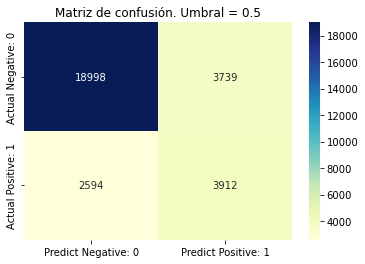

In [31]:
conf_mat(y_test, Y_pred, 0.5)

In [32]:
# Calculamos predict_proba para ver el umbral de probabilidades

y_pred_proba = gnb.predict_proba(X_test)

In [33]:
# Performance sobre datos nuevos

y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86     22737
         1.0       0.51      0.60      0.55      6506

    accuracy                           0.78     29243
   macro avg       0.70      0.72      0.70     29243
weighted avg       0.80      0.78      0.79     29243

0.7834353520500633


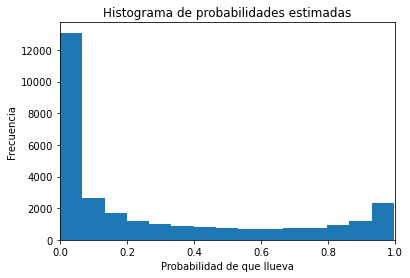

In [34]:
# Nos quedamos con la columna que tiene la probabilidad de que llueva
y_probs_logit_left = y_pred_proba[:,1]

# Generamos un histograma de esa columna
plt.hist(y_probs_logit_left, bins=15)
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas')
plt.xlabel('Probabilidad de que llueva')
plt.ylabel('Frecuencia')
plt.show()

Hay una mayor probabilidad de predecir que no va a llover

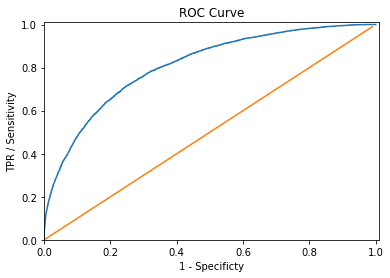

In [35]:
# Obtenemos los valores que necesitamos para graficar la curva roc

fpr_log, tpr_log, thr_log = roc_curve(y_test, y_pred_proba[:,1])  # Con y_pred_proba del modelo

# Graficamos la curva roc del modelo

df = pd.DataFrame(dict(fpr= fpr_log, tpr= tpr_log, thr= thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_log,tpr_log)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [36]:
# Calculamos el area de la curva ROC:

print('AUC =', auc(fpr_log, tpr_log))

AUC = 0.8091780784839153


<a id="section_4"></a> 
# 4 - Segundo modelado: LR
[volver a TOC](#section_toc)

In [37]:
# Eliminamos los nulos
data_sin_nulos = data.dropna()
display((100 * data_sin_nulos.isnull().sum() / data_sin_nulos.shape[0]).round(2))
display(data_sin_nulos.shape)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
Month            0.0
Year             0.0
dtype: float64

(56420, 25)

In [38]:
# Generamos dummies. dsdn == data sin nulos dummies
dsnd = pd.get_dummies(data_sin_nulos, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location', 'Month'], drop_first = True)
dsnd.head(3)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Darwin,Location_Hobart,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_NorfolkIsland,Location_Nuriootpa,Location_Perth,Location_PerthAirport,Location_Portland,Location_Sale,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_WaggaWagga,Location_Watsonia,Location_Williamtown,Location_Woomera,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
6049,2009-01-01,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0.0,0.0,2009,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6050,2009-01-02,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0.0,0.0,2009,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6052,2009-01-04,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0.0,0.0,2009,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
display(dsnd.head(3))
dsnd.shape

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Darwin,Location_Hobart,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_NorfolkIsland,Location_Nuriootpa,Location_Perth,Location_PerthAirport,Location_Portland,Location_Sale,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_WaggaWagga,Location_Watsonia,Location_Williamtown,Location_Woomera,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
6049,2009-01-01,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0.0,0.0,2009,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6050,2009-01-02,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0.0,0.0,2009,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6052,2009-01-04,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0.0,0.0,2009,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(56420, 101)

In [40]:
# Generamos dummies
dsnd2 = pd.get_dummies(data_imputados, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location_x', 'Month_x'], drop_first = True)
dsnd2.head(3)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,imputados,Location_replace,location_mes,Location_y,Month_y,"('mean', 'Cloud3pm')","('mean', 'Cloud9am')","('mean', 'Humidity3pm')","('mean', 'Sunshine')",WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Location_x_Albany,Location_x_Albury,Location_x_AliceSprings,Location_x_BadgerysCreek,Location_x_Ballarat,Location_x_Bendigo,Location_x_Brisbane,Location_x_Cairns,Location_x_Canberra,Location_x_Cobar,Location_x_CoffsHarbour,Location_x_Dartmoor,Location_x_Darwin,Location_x_GoldCoast,Location_x_Hobart,Location_x_Katherine,Location_x_Launceston,Location_x_Melbourne,Location_x_MelbourneAirport,Location_x_Mildura,Location_x_Moree,Location_x_MountGambier,Location_x_MountGinini,Location_x_Newcastle,Location_x_Nhil,Location_x_NorahHead,Location_x_NorfolkIsland,Location_x_Nuriootpa,Location_x_PearceRAAF,Location_x_Penrith,Location_x_Perth,Location_x_PerthAirport,Location_x_Portland,Location_x_Richmond,Location_x_Sale,Location_x_SalmonGums,Location_x_Sydney,Location_x_SydneyAirport,Location_x_Townsville,Location_x_WaggaWagga,Location_x_Walpole,Location_x_Watsonia,Location_x_Williamtown,Location_x_Wollongong,Location_x_Woomera,Month_x_2,Month_x_3,Month_x_4,Month_x_5,Month_x_6,Month_x_7,Month_x_8,Month_x_9,Month_x_10,Month_x_11,Month_x_12
0,2008-12-01,13.4,22.9,0.6,NaN,11.53,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.00,2.56,16.9,21.8,0.0,0.0,2008,1,Perth,Perth12,Perth,12,2.56,2.85,39.92,11.53,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2008-12-02,7.4,25.1,0.0,NaN,11.53,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,2.85,2.56,17.2,24.3,0.0,0.0,2008,1,Perth,Perth12,Perth,12,2.56,2.85,39.92,11.53,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2008-12-03,12.9,25.7,0.0,NaN,11.53,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,2.85,2.00,21.0,23.2,0.0,0.0,2008,1,Perth,Perth12,Perth,12,2.56,2.85,39.92,11.53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
dsnd2.head(3)
dsnd2.shape

(137834, 130)

In [42]:
data.Year.value_counts()

2016    17934
2015    17885
2014    17885
2009    16789
2010    16782
2013    16415
2012    15409
2011    15407
2017     8623
2008     2270
2007       61
Name: Year, dtype: int64

In [43]:
# Mascara de años para reducir df del 2010 al 2015
mask_year = (dsnd.Year > 2009) & (dsnd.Year < 2016)

# Df tiene años desde 2007 a 2017
print(dsnd.Year.value_counts())

2009    8283
2010    8130
2014    6639
2013    6475
2011    6470
2012    6465
2015    6319
2016    4561
2017    1719
2008    1298
2007      61
Name: Year, dtype: int64


In [44]:
dsnd_menos_year = dsnd[mask_year]

# Verificamos que haya quedado bien
print(dsnd_menos_year.shape)
print(dsnd_menos_year.Year.value_counts())

(40498, 101)
2010    8130
2014    6639
2013    6475
2011    6470
2012    6465
2015    6319
Name: Year, dtype: int64


In [45]:
# Armo la matriz de features sin nulos, con dummies, sin Date y sin Year:

X = dsnd_menos_year.drop(columns=['RainTomorrow', 'Date', 'Year'])
X.shape

(40498, 98)

In [46]:
y = dsnd_menos_year.RainTomorrow
y.value_counts(normalize= True)

0.0    0.777224
1.0    0.222776
Name: RainTomorrow, dtype: float64

In [47]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size= 0.3, random_state= 30, stratify= y)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28348, 98)

(12150, 98)

(28348,)

(12150,)

In [48]:
selector = FeatureSelection(selected_features= X.columns.values)

# selector_1 = FeatureSelection(selected_features=X.drop(columns='Rainfall').columns.values)
# selector_2 = FeatureSelection(selected_features=X.drop(columns='Sunshine').columns.values)

In [49]:
# Randomsearch con 1 estimador logistic --> corrió rápido

folds = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

pasos = [('feature_engineering',selector),
         ('preprocesamiento', MinMaxScaler()), 
         ('clasificador', LogisticRegression(solver='sag'))]

pipe = Pipeline(pasos)

param_grid = [{'feature_engineering':[selector],
               'preprocesamiento': [StandardScaler(), MinMaxScaler()],
               'clasificador__C': [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 5, 10, 50]}]
                            
model = RandomizedSearchCV(pipe, param_grid, cv= folds, scoring= 'f1_macro', random_state= 10)

model.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('feature_engineering',
                                              FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm',...
       'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville',
       'Location_WaggaWagga', 'Location_Watsonia', 'Location_Williamtown',
       'Location_Woomera', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12'], dtype=object))],
                                         'preprocesamiento': [StandardScaler(),
                                                              MinMaxScaler()]}],
                   scoring='f1_macro')

Veamos cómo fue la performance de este modelo

In [50]:
model.best_estimator_

Pipeline(steps=[('feature_engineering',
                 FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'Wind...
       'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville',
       'Location_WaggaWagga', 'Location_Watsonia', 'Location_Williamtown',
       'Location_Woomera', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12'], dtype=object))),
                ('preprocesamiento', StandardScaler()),
                ('clasificador', LogisticRegression(C=0.3, solver='sag'))])

In [51]:
model.best_score_

0.7715272296272554

In [52]:
model.best_params_

{'preprocesamiento': StandardScaler(),
 'feature_engineering': FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
        'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
        'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
        'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_ENE',
        'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
        'WindGustDir_NNE', 'WindGust...
        'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_Perth',
        'Location_PerthAirport', 'Location_Portland', 'Location_Sale',
        'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville',
        'Location_WaggaWagga', 'Location_Watsonia', 'Location_Williamtown',
        'Location_Woomera', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
        'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
        'Month_12'], dtype=object)),
 'clasificador__C': 0.3}

In [53]:
tabla_resultados = pd.DataFrame(model.cv_results_)
tabla_resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocesamiento,param_feature_engineering,param_clasificador__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.616572,0.082929,0.022816,0.001078,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,10,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.770904,0.773934,0.764984,0.773171,0.772677,0.771134,0.003232,5
1,0.847463,0.048577,0.025216,0.001915,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,0.05,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.758605,0.764797,0.745491,0.753507,0.754248,0.755330,0.006351,9
2,1.245926,0.100541,0.024616,0.003280,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.1,"{'preprocesamiento': StandardScaler(), 'featur...",0.771813,0.774344,0.765381,0.772448,0.772518,0.771301,0.003078,2
3,1.472480,0.148392,0.020413,0.000735,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,5,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.771105,0.773777,0.764828,0.772967,0.773245,0.771184,0.003303,4
4,1.462579,0.130806,0.023515,0.002303,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.3,"{'preprocesamiento': StandardScaler(), 'featur...",0.770750,0.774045,0.765495,0.773328,0.774019,0.771527,0.003249,1
5,1.499799,0.198869,0.024417,0.002872,StandardScaler(),FeatureSelection(selected_features=array(['Min...,5,"{'preprocesamiento': StandardScaler(), 'featur...",0.769885,0.774202,0.764943,0.773484,0.773655,0.771234,0.003497,3
6,0.941527,0.022986,0.025016,0.003811,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.01,"{'preprocesamiento': StandardScaler(), 'featur...",0.770292,0.768506,0.759683,0.768740,0.768044,0.767053,0.003762,8
7,0.618611,0.043216,0.021514,0.001872,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,0.001,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.520313,0.511640,0.524905,0.509642,0.514916,0.516283,0.005623,10
8,1.152479,0.062483,0.020513,0.000708,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,0.5,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.768924,0.770381,0.761810,0.770243,0.768659,0.768003,0.003172,7
9,1.325685,0.125310,0.020413,0.000970,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,1,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.769866,0.771434,0.761302,0.771407,0.770328,0.768867,0.003832,6


In [54]:
tabla_resultados[tabla_resultados['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocesamiento,param_feature_engineering,param_clasificador__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1.462579,0.130806,0.023515,0.002303,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.3,"{'preprocesamiento': StandardScaler(), 'featur...",0.77075,0.774045,0.765495,0.773328,0.774019,0.771527,0.003249,1


In [55]:
#Performance sobre datos nuevos:

y_pred = model.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      9443
         1.0       0.74      0.56      0.64      2707

    accuracy                           0.86     12150
   macro avg       0.81      0.75      0.77     12150
weighted avg       0.85      0.86      0.85     12150

0.8576954732510288


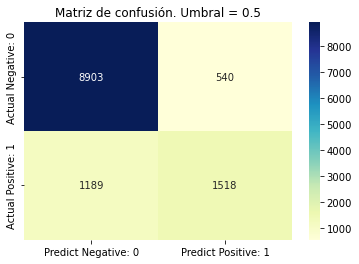

In [56]:
# Matriz de confusión

conf_mat(y_test, y_pred, 0.5)

In [57]:
# Calculamos predict_proba para ver el umbral de probabilidades
y_pred_proba = model.predict_proba(X_test)
display(y_pred_proba.shape, y_pred_proba)

(12150, 2)

array([[0.15225827, 0.84774173],
       [0.89721532, 0.10278468],
       [0.42349204, 0.57650796],
       ...,
       [0.69706275, 0.30293725],
       [0.98372632, 0.01627368],
       [0.61653143, 0.38346857]])

In [59]:
# Pertenencia calculada a partir del método .predict()
pd.Series(y_pred).value_counts()

0.0    10092
1.0     2058
dtype: int64

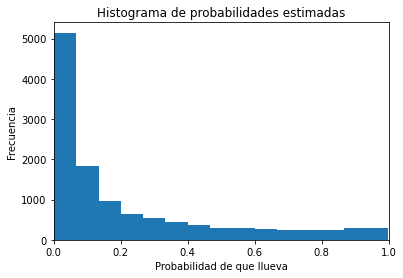

In [60]:
# Nos quedamos con la columna que tiene la probabilidad de que llueva
y_probs_logit_left = y_pred_proba[:,1]

# Generamos un histograma de esa columna
plt.hist(y_probs_logit_left, bins=15)
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas')
plt.xlabel('Probabilidad de que llueva')
plt.ylabel('Frecuencia')
plt.show()

Hay una mayor probabilidad de predecir que no va a llover

In [62]:
# Armamos otro y_pred con umbral de 0.3

y_pred_logit = (y_probs_logit_left > 0.3).astype(int)

Y_pred si cambiamos el umbral: [1 0 1 ... 1 0 1]
Y_pred: [1. 0. 1. ... 0. 0. 0.]
Y_pred_proba: [[0.15225827 0.84774173]
 [0.89721532 0.10278468]
 [0.42349204 0.57650796]
 ...
 [0.69706275 0.30293725]
 [0.98372632 0.01627368]
 [0.61653143 0.38346857]]


Matrices de confusión
——————————————————————————————————————————————————


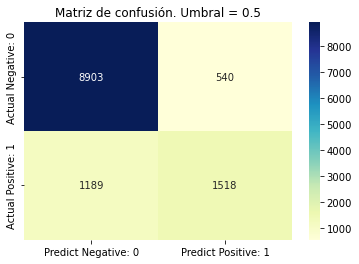

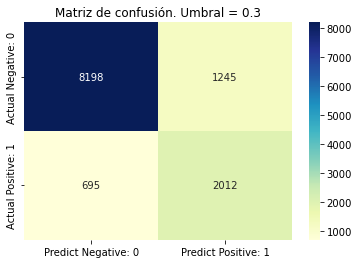

In [63]:
print('Matrices de confusión\n' + '\u2014' * 50)
conf_mat(y_test, y_pred, 0.5)
conf_mat(y_test,y_pred_logit, 0.3)

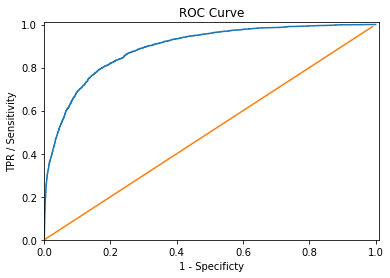

In [64]:
# Obtenemos los valores que necesitamos para graficar la curva roc

fpr_log, tpr_log, thr_log = roc_curve(y_test, y_pred_proba[:,1])  # Con y_pred_proba del modelo

# Graficamos la curva roc del modelo

df = pd.DataFrame(dict(fpr= fpr_log, tpr= tpr_log, thr= thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_log, tpr_log)
plt.plot(np.arange(0, 1, step= 0.01), np.arange(0, 1, step= 0.01))
plt.show()

In [65]:
# Calculamos el area de la curva ROC:

print('AUC =', auc(fpr_log, tpr_log))

AUC = 0.8925626944252569


Ahora repetimos los pasos anteriores pero con el df sin nulos y agregando imputados


In [66]:
# Eliminamos los nulos
data_sin_nulos_imputados = data_imputados.dropna()
display((100 * data_sin_nulos_imputados.isnull().sum() / data_sin_nulos_imputados.shape[0]).round(2))
display(data_sin_nulos_imputados.shape)

Date                       0.0
Location_x                 0.0
MinTemp                    0.0
MaxTemp                    0.0
Rainfall                   0.0
Evaporation                0.0
Sunshine                   0.0
WindGustDir                0.0
WindGustSpeed              0.0
WindDir9am                 0.0
WindDir3pm                 0.0
WindSpeed9am               0.0
WindSpeed3pm               0.0
Humidity9am                0.0
Humidity3pm                0.0
Pressure9am                0.0
Pressure3pm                0.0
Cloud9am                   0.0
Cloud3pm                   0.0
Temp9am                    0.0
Temp3pm                    0.0
RainToday                  0.0
RainTomorrow               0.0
Month_x                    0.0
Year                       0.0
imputados                  0.0
Location_replace           0.0
location_mes               0.0
Location_y                 0.0
Month_y                    0.0
('mean', 'Cloud3pm')       0.0
('mean', 'Cloud9am')       0.0
('mean',

(68448, 34)

In [67]:
# Generamos dummies
dsnd2 = pd.get_dummies(data_sin_nulos_imputados, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location_x', 'Month_x'], drop_first = True)

display(dsnd2.head(3))
dsnd2.shape

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,imputados,Location_replace,location_mes,Location_y,Month_y,"('mean', 'Cloud3pm')","('mean', 'Cloud9am')","('mean', 'Humidity3pm')","('mean', 'Sunshine')",WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Location_x_Bendigo,Location_x_Brisbane,Location_x_Cairns,Location_x_Canberra,Location_x_Cobar,Location_x_CoffsHarbour,Location_x_Darwin,Location_x_Hobart,Location_x_Katherine,Location_x_Launceston,Location_x_Melbourne,Location_x_MelbourneAirport,Location_x_Mildura,Location_x_Moree,Location_x_MountGambier,Location_x_NorfolkIsland,Location_x_Nuriootpa,Location_x_Perth,Location_x_PerthAirport,Location_x_Portland,Location_x_Richmond,Location_x_Sale,Location_x_Sydney,Location_x_SydneyAirport,Location_x_Townsville,Location_x_WaggaWagga,Location_x_Watsonia,Location_x_Williamtown,Location_x_Woomera,Month_x_2,Month_x_3,Month_x_4,Month_x_5,Month_x_6,Month_x_7,Month_x_8,Month_x_9,Month_x_10,Month_x_11,Month_x_12
248,2008-12-01,12.8,27.2,0.0,9.0,13.0,33.0,9.0,19.0,53.0,41.0,1016.4,1012.6,2.0,1.0,19.2,25.5,0.0,0.0,2008,0,Perth,Perth12,Perth,12,2.56,2.85,39.92,11.53,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
249,2008-12-02,12.2,32.7,0.0,9.0,10.4,28.0,9.0,7.0,55.0,23.0,1009.3,1004.9,6.0,2.0,20.7,31.9,0.0,0.0,2008,0,Perth,Perth12,Perth,12,2.56,2.85,39.92,11.53,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
250,2008-12-03,18.3,23.1,0.4,6.2,7.5,41.0,20.0,15.0,70.0,53.0,1002.5,1005.2,5.0,7.0,20.1,21.5,0.0,0.0,2008,0,Perth,Perth12,Perth,12,2.56,2.85,39.92,11.53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


(68448, 114)

In [68]:
data_imputados.Year.value_counts()

2016    16836
2015    16790
2014    16790
2009    16059
2010    16052
2013    15435
2012    14740
2011    14737
2017     8095
2008     2239
2007       61
Name: Year, dtype: int64

In [69]:
# Mascara de años para reducir df del 2010 al 2015
mask_year2 = (dsnd2.Year > 2009) & (dsnd2.Year < 2016)
print(dsnd2.Year[mask_year2])

310       2010
311       2010
312       2010
313       2010
314       2010
          ... 
137774    2015
137775    2015
137776    2015
137777    2015
137778    2015
Name: Year, Length: 48711, dtype: int64
2009    9027
2010    8893
2013    8410
2014    8066
2011    7971
2012    7877
2015    7494
2016    6777
2017    2511
2008    1361
2007      61
Name: Year, dtype: int64


In [70]:
dsnd2_menos_year = dsnd2[mask_year2].copy()
print(dsnd2_menos_year.shape)
print(dsnd2_menos_year.Year.value_counts())

(48711, 114)
2010    8893
2013    8410
2014    8066
2011    7971
2012    7877
2015    7494
Name: Year, dtype: int64


In [71]:
# Armo la matriz de features sin nulos, con dummies, sin Date y sin Year:

X = dsnd2_menos_year.drop(columns=['RainTomorrow','Date', 'Year', "imputados", "Location_replace", "location_mes", "Location_y", "Month_y", "('mean', 'Cloud3pm')",\
                                  "('mean', 'Cloud9am')", "('mean', 'Humidity3pm')", "('mean', 'Sunshine')" ])
X.shape

(48711, 102)

In [72]:
y = dsnd2_menos_year.RainTomorrow
y.value_counts() / y.shape[0]*100

0.0    78.553099
1.0    21.446901
Name: RainTomorrow, dtype: float64

In [73]:
# Creamos el split train/test

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size= 0.3, random_state= 30, stratify= y)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34097, 102)

(14614, 102)

(34097,)

(14614,)

In [74]:
selector=FeatureSelection(selected_features=X.columns.values)
#selector_1=FeatureSelection(selected_features=X.drop(columns='Rainfall').columns.values)
#selector_2=FeatureSelection(selected_features=X.drop(columns='Sunshine').columns.values)

folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state= 42)

# RANDOMSEARCH CON 1 ESTIMADOR LOGISTIC --> CORRIO RAPIDO
pasos = [('feature_engineering',selector),
         ('preprocesamiento', MinMaxScaler()), 
         ('clasificador', LogisticRegression(solver='sag'))]

pipe = Pipeline(pasos)

param_grid = [{'feature_engineering':[selector],
               'preprocesamiento': [StandardScaler(), MinMaxScaler()],
               'clasificador__C': [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 5, 10, 50]}]
                            
model=RandomizedSearchCV(pipe, param_grid, cv=folds, scoring = 'f1_macro', random_state= 10)

model.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('feature_engineering',
                                              FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm',...
       'Location_x_Sydney', 'Location_x_SydneyAirport',
       'Location_x_Townsville', 'Location_x_WaggaWagga',
       'Location_x_Watsonia', 'Location_x_Williamtown',
       'Location_x_Woomera', 'Month_x_2', 'Month_x_3', 'Month_x_4',
       'Month_x_5', 'Month_x_6', 'Month_x_7', 'Month_x_8', 'Month_x_9',
       'Month_x_10', 'Month_x_11', 'Month_x_12'], dtype=object))],
                                         'preprocesamiento': [StandardScaler(),
                                                              MinMaxScaler()]}],
      

Veamos cómo fue la performance de este modelo

In [75]:
model.best_estimator_

Pipeline(steps=[('feature_engineering',
                 FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'Wind...
       'Location_x_Townsville', 'Location_x_WaggaWagga',
       'Location_x_Watsonia', 'Location_x_Williamtown',
       'Location_x_Woomera', 'Month_x_2', 'Month_x_3', 'Month_x_4',
       'Month_x_5', 'Month_x_6', 'Month_x_7', 'Month_x_8', 'Month_x_9',
       'Month_x_10', 'Month_x_11', 'Month_x_12'], dtype=object))),
                ('preprocesamiento', MinMaxScaler()),
                ('clasificador', LogisticRegression(C=10, solver='sag'))])

In [76]:
model.best_score_

0.7683070792164071

In [77]:
model.best_params_

{'preprocesamiento': MinMaxScaler(),
 'feature_engineering': FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
        'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
        'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
        'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_ENE',
        'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
        'WindGustDir_NNE', 'WindGust...
        'Location_x_Portland', 'Location_x_Richmond', 'Location_x_Sale',
        'Location_x_Sydney', 'Location_x_SydneyAirport',
        'Location_x_Townsville', 'Location_x_WaggaWagga',
        'Location_x_Watsonia', 'Location_x_Williamtown',
        'Location_x_Woomera', 'Month_x_2', 'Month_x_3', 'Month_x_4',
        'Month_x_5', 'Month_x_6', 'Month_x_7', 'Month_x_8', 'Month_x_9',
        'Month_x_10', 'Month_x_11', 'Month_x_12'], dtype=object)),
 'clasificador__C': 10}

In [78]:
tabla_resultados = pd.DataFrame(model.cv_results_)
tabla_resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocesamiento,param_feature_engineering,param_clasificador__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.319983,0.053329,0.023916,0.000734,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,0.3,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.761586,0.766901,0.761169,0.754608,0.767811,0.762415,0.004742,8
1,0.999563,0.027123,0.027020,0.001644,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,0.05,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.756065,0.756951,0.746540,0.746639,0.760772,0.753393,0.005776,9
2,2.067476,0.063557,0.023816,0.000679,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,10,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.766652,0.772646,0.766722,0.761693,0.773823,0.768307,0.004433,1
3,2.133017,0.272738,0.025017,0.002409,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,50,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.765754,0.772954,0.766860,0.761670,0.773511,0.768150,0.004499,5
4,1.739560,0.053055,0.026118,0.003108,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,1,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.765303,0.769619,0.766286,0.758466,0.772715,0.766478,0.004783,7
5,1.937798,0.096221,0.025617,0.001857,StandardScaler(),FeatureSelection(selected_features=array(['Min...,1,"{'preprocesamiento': StandardScaler(), 'featur...",0.765923,0.773262,0.766552,0.761670,0.773511,0.768184,0.004569,4
6,1.810006,0.140469,0.026417,0.001657,StandardScaler(),FeatureSelection(selected_features=array(['Min...,10,"{'preprocesamiento': StandardScaler(), 'featur...",0.765894,0.772782,0.766999,0.761670,0.773649,0.768199,0.004474,2
7,0.956140,0.039939,0.027920,0.004332,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.001,"{'preprocesamiento': StandardScaler(), 'featur...",0.753358,0.751031,0.740274,0.740548,0.754896,0.748021,0.006335,10
8,1.555331,0.051355,0.028019,0.002985,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.1,"{'preprocesamiento': StandardScaler(), 'featur...",0.767023,0.771548,0.767061,0.761202,0.774134,0.768194,0.004429,3
9,2.019540,0.171424,0.027218,0.001722,StandardScaler(),FeatureSelection(selected_features=array(['Min...,5,"{'preprocesamiento': StandardScaler(), 'featur...",0.765894,0.772782,0.766999,0.761670,0.773338,0.768136,0.004400,6


In [79]:
tabla_resultados[tabla_resultados['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocesamiento,param_feature_engineering,param_clasificador__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,2.067476,0.063557,0.023816,0.000679,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,10,"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.766652,0.772646,0.766722,0.761693,0.773823,0.768307,0.004433,1


In [80]:
# Performance sobre datos nuevos:

y_pred = model.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     11480
         1.0       0.72      0.54      0.62      3134

    accuracy                           0.86     14614
   macro avg       0.80      0.74      0.77     14614
weighted avg       0.85      0.86      0.85     14614

0.8570548788832626


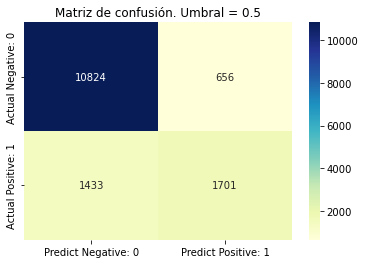

In [81]:
# Matriz de confusión

conf_mat(y_test, y_pred, 0.5)

In [82]:
# Calculamos predict_proba para ver el umbral de probabilidades

y_pred_proba = model.predict_proba(X_test)
display(y_pred_proba.shape, y_pred_proba)

(14614, 2)

array([[0.04448424, 0.95551576],
       [0.30323206, 0.69676794],
       [0.07453438, 0.92546562],
       ...,
       [0.91044733, 0.08955267],
       [0.95286664, 0.04713336],
       [0.97793808, 0.02206192]])

In [85]:
# Pertenencia calculada a partir del método .predict()
pd.Series(y_pred).value_counts()

0.0    12257
1.0     2357
dtype: int64

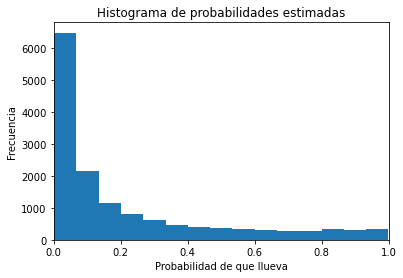

In [86]:
# Nos quedamos con la columna que tiene la probabilidad de que llueva
y_probs_logit_left = y_pred_proba[:,1]

# Generamos un histograma de esa columna
plt.hist(y_probs_logit_left, bins=15)
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas')
plt.xlabel('Probabilidad de que llueva')
plt.ylabel('Frecuencia')
plt.show()
#Hay una mayor probabilidad de predecir que no va a llover

In [87]:
y_pred_logit = (y_probs_logit_left > 0.3).astype(int)
print("Y_pred si cambiamos el umbral:", y_pred_logit)
print("Y_pred:", y_pred)
print("Y_pred_proba:", y_pred_proba)

Y_pred si cambiamos el umbral: [1 1 1 ... 0 0 0]
Y_pred: [1. 1. 1. ... 0. 0. 0.]
Y_pred_proba: [[0.04448424 0.95551576]
 [0.30323206 0.69676794]
 [0.07453438 0.92546562]
 ...
 [0.91044733 0.08955267]
 [0.95286664 0.04713336]
 [0.97793808 0.02206192]]


Matrices de confusión
——————————————————————————————————————————————————


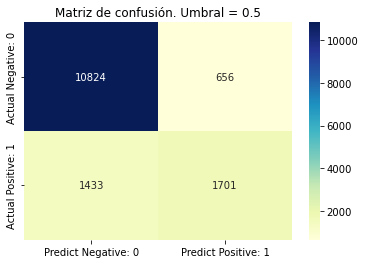

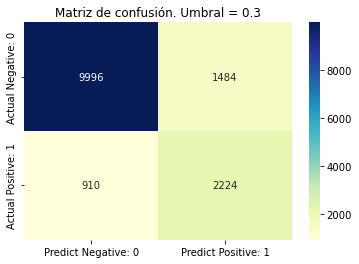

In [88]:
print('Matrices de confusión\n' + '\u2014' * 50)
conf_mat(y_test, y_pred, 0.5)
conf_mat(y_test,y_pred_logit, 0.3)

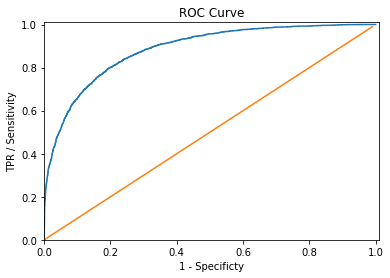

In [89]:
# Obtenemos los valores que necesitamos para graficar la curva roc

fpr_log, tpr_log, thr_log = roc_curve(y_test, y_pred_proba[:,1])  # Con y_pred_proba del modelo


# Graficamos la curva roc del modelo
df = pd.DataFrame(dict(fpr= fpr_log, tpr= tpr_log, thr= thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_log, tpr_log)
plt.plot(np.arange(0, 1, step= 0.01), np.arange(0, 1, step= 0.01))
plt.show()

In [90]:
# Calculamos el area de la curva ROC:

print('AUC =', auc(fpr_log, tpr_log))

AUC = 0.8850396572157899


<a id="section_5"></a> 
# 5 - Tercer modelado: LR & KNN
[volver a TOC](#section_toc)

In [91]:
# RandomSearch con dos estimadores: KNN y LOGISTIC -> CORRIO EN 20 MIN
pasos = [('feature_engineering',selector),
         ('preprocesamiento', MinMaxScaler()), 
         ('clasificador', LogisticRegression(solver='sag'))]

pipe = Pipeline(pasos)

param_grid = [{'feature_engineering':[selector],
               'preprocesamiento': [StandardScaler(), MinMaxScaler()],
               'clasificador__C': [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 5, 10, 50]},
              {'feature_engineering':[selector],
               'preprocesamiento':[StandardScaler(), MinMaxScaler()], 
               'clasificador': [KNeighborsClassifier()],
               'clasificador__n_neighbors':range(2,20,2),'clasificador__weights':['uniform','distance']}]
              
model = RandomizedSearchCV(pipe, param_grid, cv= folds, scoring= 'f1_macro', random_state= 10)

model.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('feature_engineering',
                                              FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm',...
       'Location_x_Sydney', 'Location_x_SydneyAirport',
       'Location_x_Townsville', 'Location_x_WaggaWagga',
       'Location_x_Watsonia', 'Location_x_Williamtown',
       'Location_x_Woomera', 'Month_x_2', 'Month_x_3', 'Month_x_4',
       'Month_x_5', 'Month_x_6', 'Month_x_7', 'Month_x_8', 'Month_x_9',
       'Month_x_10', 'Month_x_11', 'Month_x_12'], dtype=object))],
                                         'preprocesamiento': [StandardScaler(),
                                                              MinMaxScaler()]}],
      

Veamos la performance de este modelo

In [92]:
model.best_estimator_

Pipeline(steps=[('feature_engineering',
                 FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'Wind...
       'Location_x_Townsville', 'Location_x_WaggaWagga',
       'Location_x_Watsonia', 'Location_x_Williamtown',
       'Location_x_Woomera', 'Month_x_2', 'Month_x_3', 'Month_x_4',
       'Month_x_5', 'Month_x_6', 'Month_x_7', 'Month_x_8', 'Month_x_9',
       'Month_x_10', 'Month_x_11', 'Month_x_12'], dtype=object))),
                ('preprocesamiento', StandardScaler()),
                ('clasificador', LogisticRegression(C=0.3, solver='sag'))])

In [93]:
model.best_score_

0.7683364156634708

In [94]:
model.best_params_

{'preprocesamiento': StandardScaler(),
 'feature_engineering': FeatureSelection(selected_features=array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
        'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
        'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
        'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_ENE',
        'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
        'WindGustDir_NNE', 'WindGust...
        'Location_x_Portland', 'Location_x_Richmond', 'Location_x_Sale',
        'Location_x_Sydney', 'Location_x_SydneyAirport',
        'Location_x_Townsville', 'Location_x_WaggaWagga',
        'Location_x_Watsonia', 'Location_x_Williamtown',
        'Location_x_Woomera', 'Month_x_2', 'Month_x_3', 'Month_x_4',
        'Month_x_5', 'Month_x_6', 'Month_x_7', 'Month_x_8', 'Month_x_9',
        'Month_x_10', 'Month_x_11', 'Month_x_12'], dtype=object)),
 'clasificador__C': 0.3}

In [95]:
tabla_resultados = pd.DataFrame(model.cv_results_)
tabla_resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocesamiento,param_feature_engineering,param_clasificador__C,param_clasificador__weights,param_clasificador__n_neighbors,param_clasificador,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.851537,0.084289,0.026317,0.001471,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.3,NaN,NaN,NaN,"{'preprocesamiento': StandardScaler(), 'featur...",0.766543,0.773090,0.766860,0.761989,0.773200,0.768336,0.004288,1
1,1.311972,0.036560,0.025417,0.000584,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.05,NaN,NaN,NaN,"{'preprocesamiento': StandardScaler(), 'featur...",0.766093,0.771618,0.766706,0.759409,0.773787,0.767523,0.004991,3
2,2.552392,0.221876,65.586387,1.828219,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,NaN,uniform,14,KNeighborsClassifier(),"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.621097,0.618943,0.618034,0.618018,0.619848,0.619188,0.001170,8
3,2.392790,0.194866,52.979563,0.675183,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,NaN,uniform,2,KNeighborsClassifier(),"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.606378,0.585967,0.596383,0.597054,0.599255,0.597007,0.006560,10
4,2.567720,0.076724,59.428366,0.619457,StandardScaler(),FeatureSelection(selected_features=array(['Min...,NaN,distance,12,KNeighborsClassifier(),"{'preprocesamiento': StandardScaler(), 'featur...",0.650911,0.644942,0.637868,0.632991,0.645954,0.642533,0.006333,6
5,1.515405,0.067440,0.025417,0.001393,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.1,NaN,NaN,NaN,"{'preprocesamiento': StandardScaler(), 'featur...",0.767023,0.771548,0.767061,0.761202,0.774134,0.768194,0.004429,2
6,2.406523,0.176167,60.289109,1.901275,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,NaN,uniform,6,KNeighborsClassifier(),"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.633054,0.620276,0.617413,0.608754,0.620092,0.619918,0.007793,7
7,2.770172,0.341588,80.078340,8.320880,MinMaxScaler(),FeatureSelection(selected_features=array(['Min...,NaN,distance,14,KNeighborsClassifier(),"{'preprocesamiento': MinMaxScaler(), 'feature_...",0.651485,0.646487,0.641473,0.647947,0.647930,0.647064,0.003245,5
8,4.605502,0.603951,93.673338,9.786488,StandardScaler(),FeatureSelection(selected_features=array(['Min...,NaN,distance,6,KNeighborsClassifier(),"{'preprocesamiento': StandardScaler(), 'featur...",0.657483,0.661004,0.655765,0.645624,0.664664,0.656908,0.006417,4
9,4.179381,0.428065,87.436863,1.530453,StandardScaler(),FeatureSelection(selected_features=array(['Min...,NaN,uniform,4,KNeighborsClassifier(),"{'preprocesamiento': StandardScaler(), 'featur...",0.619356,0.618623,0.608932,0.595942,0.618205,0.612211,0.008984,9


In [96]:
tabla_resultados[tabla_resultados['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocesamiento,param_feature_engineering,param_clasificador__C,param_clasificador__weights,param_clasificador__n_neighbors,param_clasificador,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.851537,0.084289,0.026317,0.001471,StandardScaler(),FeatureSelection(selected_features=array(['Min...,0.3,NaN,NaN,NaN,"{'preprocesamiento': StandardScaler(), 'featur...",0.766543,0.77309,0.76686,0.761989,0.7732,0.768336,0.004288,1


In [97]:
# Performance sobre datos nuevos:

y_pred = model.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     11480
         1.0       0.72      0.54      0.62      3134

    accuracy                           0.86     14614
   macro avg       0.80      0.74      0.77     14614
weighted avg       0.85      0.86      0.85     14614

0.857191733953743


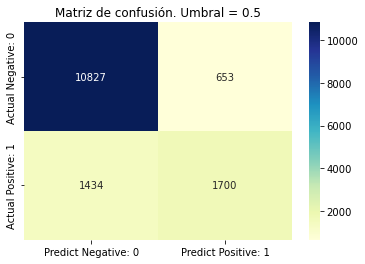

In [98]:
# Matriz de confusión

conf_mat(y_test, y_pred, 0.5)

In [99]:
# Calculamos predict_proba para ver el umbral de probabilidades

y_pred_proba = model.predict_proba(X_test)
display(y_pred_proba.shape, y_pred_proba)

(14614, 2)

array([[0.04340783, 0.95659217],
       [0.30460465, 0.69539535],
       [0.07322203, 0.92677797],
       ...,
       [0.91036371, 0.08963629],
       [0.95302289, 0.04697711],
       [0.97772659, 0.02227341]])

In [100]:
pd.Series(y_pred_proba[:,1]>0.5).astype(int).value_counts()

0    12261
1     2353
dtype: int64

In [101]:
y_pred

array([1., 1., 1., ..., 0., 0., 0.])

In [102]:
# Pertenencia calculada a partir del método .predict()

pd.Series(y_pred).value_counts()

0.0    12261
1.0     2353
dtype: int64

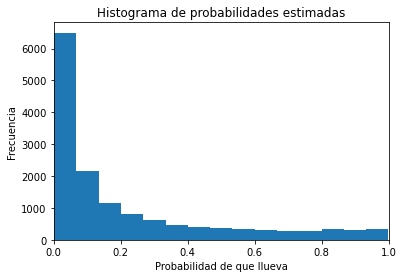

In [103]:
# Nos quedamos con la columna que tiene la probabilidad de que llueva
y_probs_logit_left = y_pred_proba[:,1]

# Generamos un histograma de esa columna
plt.hist(y_probs_logit_left, bins=15)
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas')
plt.xlabel('Probabilidad de que llueva')
plt.ylabel('Frecuencia')
plt.show()
# Hay una mayor probabilidad de predecir que no va a llover

In [104]:
y_probs_logit_left

array([0.95659217, 0.69539535, 0.92677797, ..., 0.08963629, 0.04697711,
       0.02227341])

In [105]:
y_pred_logit = (y_probs_logit_left > 0.3).astype(int)
print("Y_pred si cambiamos el umbral:", y_pred_logit)
print("Y_pred:", y_pred)
print("Y_pred_proba:", y_pred_proba)

Y_pred si cambiamos el umbral: [1 1 1 ... 0 0 0]
Y_pred: [1. 1. 1. ... 0. 0. 0.]
Y_pred_proba: [[0.04340783 0.95659217]
 [0.30460465 0.69539535]
 [0.07322203 0.92677797]
 ...
 [0.91036371 0.08963629]
 [0.95302289 0.04697711]
 [0.97772659 0.02227341]]


Matrix Original


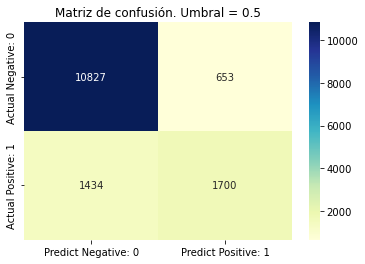

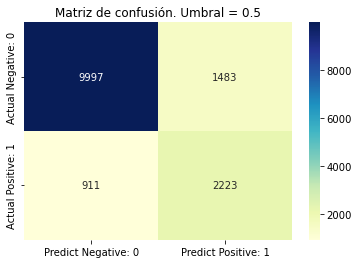

In [106]:
print('Matrix Original')

conf_mat(y_test,y_pred, 0.5)
conf_mat(y_test,y_pred_logit, 0.5)

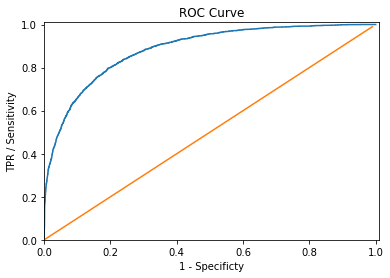

In [107]:
# Obtenemos los valores que necesitamos para graficar la curva roc

fpr_log, tpr_log, thr_log = roc_curve(y_test, y_pred_proba[:,1])  # Con y_pred_proba del modelo

# Graficamos la curva roc del modelo

df = pd.DataFrame(dict(fpr= fpr_log, tpr= tpr_log, thr= thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_log, tpr_log)
plt.plot(np.arange(0, 1, step= 0.01), np.arange(0, 1, step= 0.01))
plt.show()

In [108]:
# Calculamos el area de la curva ROC:

print('AUC =', auc(fpr_log, tpr_log))

AUC = 0.8850661731842954


<a id="section_6"></a> 
# 6 - Modelos no usados para la presentación
[volver a TOC](#section_toc)

En general estos modelos tardaron demasiado tiempo en correr o bien son redundantes pues ya fueron aplicados en otro pipeline

In [109]:
# RANDOMSEARCH CON 1 ESTIMADOR KNN --> CORRIO EN 30 MIN
# pasos_1 = [('feature_engineering',selector),
#          ('preprocesamiento', MinMaxScaler()), 
#          ('clasificador', KNeighborsClassifier())]

# pipe_1=Pipeline(pasos_1)

# param_grid = [{'feature_engineering':[selector],
#                'preprocesamiento':[StandardScaler(), MinMaxScaler()], 
#                'clasificador': [KNeighborsClassifier()],
#                'clasificador__n_neighbors':range(2,20,2),'clasificador__weights':['uniform','distance']}]
              
# model=RandomizedSearchCV(pipe_1, param_grid, cv=folds, scoring = 'f1_macro', random_state= 10)

# model.fit(X_train,y_train)

In [110]:
# GRIDSEARCH CON 2 ESTIMADORES -> CORRIO EN MUCHAS HORAS

# pasos = [('feature_engineering',selector),
#         ('preprocesamiento', MinMaxScaler()), 
#         ('clasificador', LogisticRegression(solver='sag'))]

# pipe=Pipeline(pasos)

# param_grid = [{'feature_engineering':[selector],#selector_1, selector_2, None],
#               'preprocesamiento': [StandardScaler(), MinMaxScaler()],
#               'clasificador__C': [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 5, 10, 50]},
#              {'feature_engineering':[selector],#selector_1, selector_2, None],
#               'preprocesamiento':[StandardScaler(), MinMaxScaler()], 
#               'clasificador': [KNeighborsClassifier()],
#               'clasificador__n_neighbors':range(2,20,2),'clasificador__weights':['uniform','distance']}]
              
# model=GridSearchCV(pipe, param_grid, cv=folds, scoring = 'f1_macro')

# model.fit(X_train,y_train)

In [111]:
# GRIDSEARCH CON 3 ESTIMADORES -> CORRIO EN MUCHISIMAS HORAS

# pasos = [('feature_engineering',selector),
#         ('preprocesamiento', MinMaxScaler()), 
#         ('clasificador', LogisticRegression(solver='sag'))]

# pipe=Pipeline(pasos)

# param_grid = [{'feature_engineering':[selector],#selector_1, selector_2, None],
#               'preprocesamiento': [StandardScaler(), MinMaxScaler()],
#               'clasificador__C': [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 5, 10, 50]},
#              {'feature_engineering':[selector],#selector_1, selector_2, None],
#               'preprocesamiento':[StandardScaler(), MinMaxScaler()], 
#               'clasificador': [KNeighborsClassifier()],
#               'clasificador__n_neighbors':range(2,20,2),'clasificador__weights':['uniform','distance']},
#              {'feature_engineering':[selector],#selector_1, selector_2, None],
#               'preprocesamiento':[StandardScaler(), MinMaxScaler()], 
#               'clasificador': [SVC(gamma="auto")],
#               'clasificador__C': [ 0.1, 1, 10, 100],
#               'clasificador__gamma': [1, 0.1, 0.01],
#               'clasificador__kernel': ['rbf', 'sigmoid']}]

# model=GridSearchCV(pipe, param_grid, cv=folds, scoring = 'f1_macro')

# model.fit(X_train,y_train)